In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from dev_utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [4]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)
input_size = (64, 64)
output_size = (64, 64)
images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [5]:
def pad_image(image, pad_ratio):
    '''
        input : original image, padding_ratio( ragne 0~1 )
        output : padded_image(reflected boundary)
    '''
    original_size = (image.shape[0], image.shape[1])
    top = bottom = int(original_size[0] * pad_ratio)
    left = right = int(original_size[1] * pad_ratio)
    padded_image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_REFLECT)
    return padded_image

In [6]:
def py_image_process(image, motion_vectors, tps_random_rate, output_size):
    #image = tf.keras.applications.vgg16.preprocess_input(image)
    image = image.numpy()
    tps_random_rate = tps_random_rate.numpy()
    image = image / 255.
    padded_image = pad_image(image, tps_random_rate)
    
    ratio = 1/(1 + tps_random_rate)
    control_points = tf.constant([[-ratio, -ratio], [0.0, -ratio], [ratio, -ratio],
                               [-ratio, 0.0], [0.0, 0.0], [ratio, 0.0],
                               [-ratio, ratio], [0.0, ratio], [ratio, ratio]], dtype=tf.float32)
    x_s, y_s = tps(control_points[tf.newaxis,::], -motion_vectors[tf.newaxis,::], padded_image.shape[0:2])
    synth_image = cv2.remap(padded_image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC)
    dH = (synth_image.shape[0] - image.shape[0])/2
    dW = (synth_image.shape[1] - image.shape[1])/2
    dH, dW = int(dH), int(dW)
    synth_image = synth_image[dH:-dH, dW:-dW]    
    return image, synth_image, motion_vectors

In [7]:
def tf_image_process(image, tps_random_rate, output_size):
    motion_vectors = (tf.random.uniform([9, 2]) - 0.5) * 2 * tps_random_rate
    return tf.py_function(py_image_process, [image, motion_vectors, tps_random_rate, output_size], [tf.float32, tf.float32, tf.float32])

In [8]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)

ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(16)

In [9]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 64, 64, 3) (10, 64, 64, 3)
(10, 9, 2)


In [ ]:
plt.imshow(images[0]/255)

In [ ]:
plt.imshow(A[1])

In [ ]:
plt.imshow(B[1])

# 2. Model definition

In [ ]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block3_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [ ]:
vgg16.summary()

In [10]:
# (b) channel-wise l2 normalization
def feature_l2_normalization(feature_map):
    #input(feature map) has tensor-shape (N, H, W, D)
    l2_norm = tf.math.sqrt(tf.reduce_sum(tf.pow(feature_map, 2), axis=-1))  # (N, H, W)
    l2_norm = tf.expand_dims(l2_norm, axis=-1)  # (N, H, W, 1)
    # (N, H, W, D) tensor divided by (N, H, W, 1) tensor
    return feature_map / (l2_norm+1E-5)

In [11]:
# (c) Matching layer
class Correlation_network(tf.keras.layers.Layer):
    def __init__(self):
        super(Correlation_network, self).__init__()

    def call(self, feature_A, feature_B):
        # featureA : feature information from source image
        # featureB : feature information from target image
        #assert feature_A.shape == feature_B.shape
        # new feature A and feature B have new shape of tensors.
        # featureA has tensor shape as [batch, HA, WA, 1, 1, depth]
        # featureB has tensor shape as [batch, 1, 1, HB, WB, depth]
        feature_A = feature_A[:, :, :, tf.newaxis, tf.newaxis, :]
        feature_B = feature_B[:, tf.newaxis, tf.newaxis, :, :, :]
        # correlation score has tensor shape as [batch, HA, WA, HB, WB]
        corr_score = tf.reduce_sum(tf.multiply(feature_A, feature_B), axis=-1)
        return corr_score
# repeat penalty
def normalize_correlation(corr_score):
    ambiguous_match_penalty = tf.math.sqrt(tf.reduce_sum(tf.pow(corr_score, 2), axis=[3, 4], keepdims=True))
    corr_score = tf.math.divide(corr_score, ambiguous_match_penalty+0.00001)
    # see eq (2) in "End-to-end weakly-supervised semantic alignment"
    return corr_score

In [ ]:
feature_A = feature_extractor(A)
feature_B = feature_extractor(B)
print(feature_A.shape, feature_B.shape)

In [ ]:
normalized_feature_A = feature_l2_normalization(feature_A)
normalized_feature_B = feature_l2_normalization(feature_B)
print(normalized_feature_A.shape, normalized_feature_B.shape)

In [ ]:
correlation_net = Correlation_network()
correlations = correlation_net(normalized_feature_A, normalized_feature_B)
print(correlations.shape)

In [ ]:
correlations = tf.keras.layers.Activation("relu")(correlations)
correlations = normalize_correlation(correlations)

In [12]:
# (d) regressor
class Spatial_regressor(tf.keras.layers.Layer):
    def __init__(self, num_param):
        super(Spatial_regressor, self).__init__()
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, (7, 7)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (5, 5)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_param),
        ])
    def call(self, x):
        AH,AW,BHW = x.shape[1], x.shape[2], x.shape[3]*x.shape[4]
        x = tf.reshape(x, [-1, AH, AW, BHW])
        x = self.regressor(x)
        x = tf.reshape(x, [-1, 9, 2])
        return x

In [13]:
spatial_regressor = Spatial_regressor(9*2)
geo_parameters = spatial_regressor(correlations)
print(geo_parameters.shape)

NameError: name 'correlations' is not defined

In [14]:
class CNN_geotransform(tf.keras.Model):
    def __init__(self, feature_extractor, num_param):
        super(CNN_geotransform, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = Spatial_regressor(9*2)
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)
        return geo_parameters

In [ ]:
cnngeo = CNN_geotransform(feature_extractor, 9*2)

In [ ]:
geo_paramters = cnngeo(A, B)

In [ ]:
cnngeo.summary()

In [ ]:
geo_paramters.shape

# 3.Training

In [15]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block3_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
cnngeo = CNN_geotransform(feature_extractor, 9*2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

In [16]:
'''
def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean
'''
def loss_fn(preds, labels):
    loss_mean = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.pow(preds - labels, 2), axis = [-1])))
    return loss_mean

@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [17]:
train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(200):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

Epoch 1, Loss: 0.31400826573371887
Epoch 2, Loss: 0.3253183960914612
Epoch 3, Loss: 0.31519174575805664
Epoch 4, Loss: 0.3133406639099121
Epoch 5, Loss: 0.30335497856140137
Epoch 6, Loss: 0.3057379424571991
Epoch 7, Loss: 0.311604380607605
Epoch 8, Loss: 0.317351371049881
Epoch 9, Loss: 0.28446561098098755
Epoch 10, Loss: 0.3153432607650757
Epoch 11, Loss: 0.3055664896965027
Epoch 12, Loss: 0.29263973236083984
Epoch 13, Loss: 0.2795020341873169
Epoch 14, Loss: 0.3095294237136841
Epoch 15, Loss: 0.3206835985183716
Epoch 16, Loss: 0.2815673053264618
Epoch 17, Loss: 0.30141451954841614
Epoch 18, Loss: 0.319759339094162
Epoch 19, Loss: 0.31777554750442505
Epoch 20, Loss: 0.2925565838813782
Epoch 21, Loss: 0.30385348200798035
Epoch 22, Loss: 0.28695186972618103
Epoch 23, Loss: 0.29637253284454346
Epoch 24, Loss: 0.31630659103393555
Epoch 25, Loss: 0.3136518597602844
Epoch 26, Loss: 0.2931460440158844
Epoch 27, Loss: 0.30228328704833984
Epoch 28, Loss: 0.31240400671958923
Epoch 29, Loss: 0.2

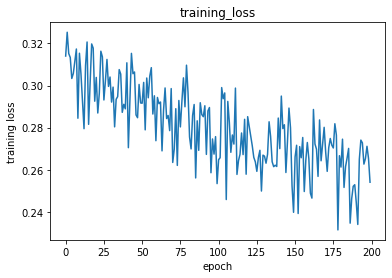

In [18]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [19]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

(10, 64, 64, 3) (10, 64, 64, 3)


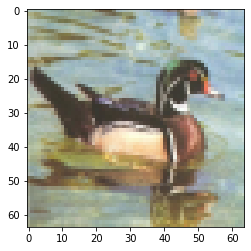

In [20]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


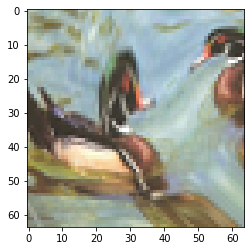

In [21]:
plt.imshow(B[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


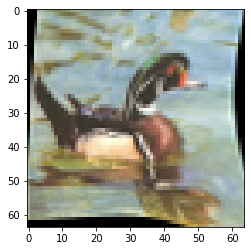

In [22]:
plt.imshow(warping_images[1])

In [ ]:
x = tf.keras.applications.vgg16.preprocess_input(np.ones([3,3,3]))

In [ ]:
x

In [ ]:
restore_original_image_from_array(x)

In [ ]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

In [ ]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

In [ ]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)